In [54]:
import os;
import json;
import builtins
import duckdb
import pandas as pd;
import matplotlib.pyplot as plt

def get_dataset_from_testcase(run):
    return run[5:-2]

dir = '/home/chesetti/Repos/learned_merge_cleanup/sponge/eps_study'
runs = []
for test_case in os.listdir(dir):
    if test_case == 'build':
        continue
    for run_name in os.listdir(os.path.join(dir, test_case, 'outputs', 'results', 'run')):
        json_file = builtins.open(os.path.join(dir, test_case, 'outputs', 'results', 'run', run_name))
        run = (json.load(json_file))
        run['dataset'] = get_dataset_from_testcase(test_case)
        runs.append(run)
df = pd.json_normalize(runs)
print(df.columns)

Index(['command', 'dataset', 'result.checksum', 'result.duration_ns',
       'result.duration_sec', 'result.inner_disk_fetch',
       'result.inner_disk_fetch_size', 'result.inner_total_bytes_fetched',
       'result.outer_disk_fetch', 'result.outer_disk_fetch_size',
       'result.outer_total_bytes_fetched', 'spec.algo', 'spec.algo_name',
       'spec.check_checksum', 'spec.common_key', 'spec.index.search',
       'spec.index.type', 'spec.inner_table', 'spec.key_size', 'spec.key_type',
       'spec.load_sstable_in_mem', 'spec.name', 'spec.num_threads',
       'spec.outer_table', 'spec.result_path', 'spec.value_size',
       'spec.write_result_to_disk'],
      dtype='object')


In [55]:

epsilon = {
    "pgm256": 256,
    "pgm1024": 1024,
    "pgm2048": 2048,
    "flatpgm256": 256,
    "flatpgm1024": 1024,
    "flatpgm2048": 2048,
    "flatpgm4096": 4096,
    "flatpgm8192": 8192,
    "hashjoin": 0,
    "btree": 0,
    "sj": 0,
    "sj2": 0,
    "standard_merge": 0
};
def indexType(x):
    if "pgm" in x:
        return "PGM"
    elif "btree" in x:
        return "BTREE"
    return "NA"

df["threads"] = df["spec.num_threads"]
df["duration_sec"] = df["result.duration_ns"] / (1000000000)
df["ratio"] = df["spec.common_key"]
df["algo"] = df["spec.algo_name"]
df["inner_bytes_fetched"] = df["result.inner_total_bytes_fetched"]
df["epsilon"] = df["spec.algo_name"].map(lambda x: epsilon[str(x).lower()])
df["index_type"] = df["spec.algo_name"].map(lambda x: indexType(x))


In [62]:
# Ratio = 1, epsilon vs duration across multiple threads
def plot_for_ratio(ratio):
    rows = duckdb.sql(
        " SELECT threads, ratio, epsilon, algo, index_type, AVG(duration_sec) as v FROM df"
        f" WHERE ratio={ratio} AND epsilon > 0"
        " GROUP BY ratio, threads, index_type, epsilon, algo"
        " ORDER BY ratio, threads, epsilon"
    ).df()
    rows.pivot(index='epsilon', values='v', columns=['threads']).plot(marker='o')
    plt.title(f"Ratio = {ratio}")
    plt.xlabel("Epsilon")
    plt.ylabel("Runtime(sec)")
    plt.show()


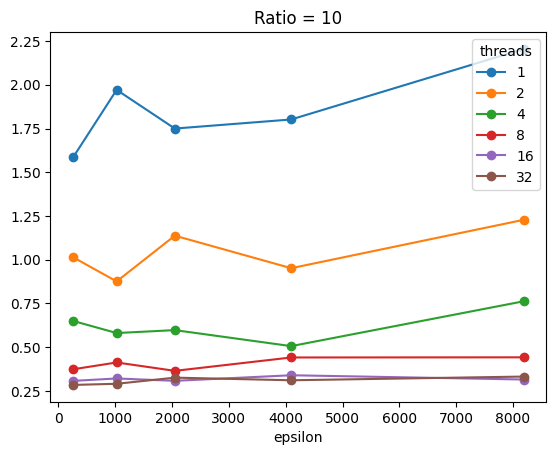

In [61]:
# Ratio = 1, epsilon vs duration across multiple threads
plot_for_ratio(1)
plot_for_ratio(10)
plot_for_ratio(100)
plot_for_ratio(1000)